# Pr√©-requis et packages n√©cessaires

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
pd.options.mode.chained_assignment = None
import math
from datetime import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import sys
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from tqdm import tqdm
pyLDAvis.enable_notebook()
from tabulate import tabulate
import seaborn as sns
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carolineboudier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carolineboudier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# I. Extraction des donn√©es

La premi√®re √©tape est d'extraire les tweets gr√¢ce √† l'API twitter. Le code complet d'extraction a √©t√© joint (fichier "Fichier_Final_Extraction" ) mais dans les grandes lignes le travail consiste √† : 
- d√©finir les **param√®tres de la recherche.** Dans notre cas nous allons nous int√©resser aux tweets *en fran√ßais* sur une p√©riode d'*une semaine* (08/01/2021 au 13/01/2021). Une premi√®re analyse sur Twitter permet de remarquer que la plupart des tweets d'opinion sur le vaccin ne sont pas d√¥t√©s du hashtag #vaccin. Pour ne pas biaiser l'√©tude (et notamment parce que les hashtags semblent √™tre plus utilis√©s par certains acteurs sp√©cifiques : m√©dias, cha√Ænes d'information), on d√©cide d'inclure *tous les tweets portant la mention "vaccin"* (qui peut aussi √™tre le radical du mot ie vaccination, vaccin√©s, vaccinent etc.)
- faire une **query sur l'API** en indiquant comme param√®tres : les dates, la langue, le filtre utilis√©. Compte tenu du nombre important de tweets, la requ√™te doit √™tre faite en plusieurs fois. On n'inclue volontairement pas les retweets dans l'analyse pour √©viter d'avoir trop de doublons. 
- √Ä partir de la donn√©e brute extraite sur Twitter, **structurer la donn√©e** dans un dataframe dont les colonnes reprennent des informations *sur le tweet* (id, contenu, date, g√©olocalisation, hashtag, cat√©gorie du tweet : citation, r√©ponse √† un autre tweet) et sur *l'utilisateur* (nom, description, localisation, date de cr√©ation, nombre de followers, nombre de favoris, utilisateur v√©rifi√© ou non). 

In [554]:
# on cr√©e le df
tw_data=pd.read_csv('clean_and_final_data.csv')
print("Le dataset comporte {} tweets".format(len(tw_data)))

Le dataset comporte 42557 tweets


In [555]:
tw_data.head()

tweet_id                 date  \
0  1348781696041279489  2021-01-11 23:59:50   
1  1348781685333241860  2021-01-11 23:59:47   
2  1348781616324354048  2021-01-11 23:59:31   
3  1348781548217245698  2021-01-11 23:59:14   
4  1348781543330893825  2021-01-11 23:59:13   

                                                text  tweet_location hashtags  \
0  hahaha y‚Äôa des gens ils veulent trop faire les...             NaN      NaN   
1  @JJBourdin_RMC Un personne peut √™tre anti-vacc...             NaN      NaN   
2  @anosylx @NassiraELM @clobala2 Le vaccin c'est...             NaN      NaN   
3  @glamchloo_ C‚Äôest soit ils gardent couvre feu ...             NaN      NaN   
4  @kassem_romain @QuentinChaine @DIVIZIO1 Dans t...             NaN      NaN   

   is_retweet       is_reply  is_quote_status              user_name  \
0       False            NaN             True               Pazzoüá´üá∑üëΩ   
1       False  JJBourdin_RMC            False            Ysa Bellule   
2       False        anosylx            False     R√©mi-Ange Couzinet   
3       False     glamchloo_            False  Alossss dans l‚Äôcosmos   
4       False  kassem_romain            False           Habib Richer   

                 user_location  \
0                      mtp zoo   
1                       France   
2              Roubaix, France   
3  Ardennes, Champagne-Ardenne   
4                          NaN   

                                    user_description         user_created  \
0            Montpellier Fans. soldat d‚Äôla team @jul  2020-10-30 11:40:01   
1                                                NaN  2019-12-15 17:47:30   
2  m√©diateur social solidaire de toutes les vies ...  2013-01-24 12:06:50   
3                                                NaN  2014-06-07 20:28:37   
4                             Un simple observateur.  2020-08-13 10:14:01   

   user_followers  user_favourites  user_verified  
0           376.0           5620.0          False  
1            13.0           5214.0          False  
2           583.0          54273.0          False  
3           262.0           9951.0          False  
4            18.0            257.0          False

In [83]:
# On affiche les donn√©es du premier tweet pour se familiariser avec les donn√©es
for column in tw_data.columns:
  print(column + " : "+str(tw_data[column][0]))

tweet_id : 1348781696041279489
date : 2021-01-11 23:59:50
text : hahaha y‚Äôa des gens ils veulent trop faire les rebelles √† pas vouloir le vaccin mais quand va falloir le montrer pour aller au cin√© ou √† l‚Äôh√¥tel avec une meuf ils vont vite courir le faire https://t.co/dmYrY5bO7y
tweet_location : nan
hashtags : nan
is_retweet : False
is_reply : nan
is_quote_status : True
user_name : Pazzoüá´üá∑üëΩ
user_location : mtp zoo
user_description : Montpellier Fans. soldat d‚Äôla team @jul
user_created : 2020-10-30 11:40:01
user_followers : 376.0
user_favourites : 5620.0
user_verified : False


# II. Nettoyage des donn√©es textuelles

Un des d√©fis les plus importants dans l'analyse de tweets est d'arriver √† une donn√©e de qualit√©. Pour ce faire on cr√©e une fonction clean_tweet dont l'objectif est de renvoyer un tweet propre √† partir d'un tweet brut. On rajoute ensuite deux colonnes au dataframe (donn√©e propre sous forme de vecteurs et sous forme de liste de mots). 

## 1) Pr√©-requis

In [84]:
# On cr√©e une stoplist √† laquelle on rajoute quelques √©l√©ments par la suite
stoplist = stopwords.words('french')
rajouts_stoplist=['√ßa','a','fait','tout']
stoplist = stoplist+rajouts_stoplist

# on s'assure de ne pas supprimer les @ pour pouvoir ensuite identifier les tags
string_punc=string.punctuation.replace('@','')+str('¬´')+str('¬´')

# on s'assure √©galement de supprimer les emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

## 2) Fonction clean_tweet()

In [86]:
# on peut maintenant cr√©er la fonction clean_tweet
def clean_tweet(tweet):
  # on remplace les apostrophes par des espaces
    tweet=tweet.replace('\''," ")
    tweet=tweet.replace('‚Äô'," ")

  # on retire la ponctuation (sauf les @)
    for char in string_punc:
        tweet=tweet.replace(char,'')
    # on retire les √©mojis
        tweet=remove_emoji(tweet)
    final_vec=[]
    for word in tweet.split():
    # minuscules
        word=word.lower()
    # on retire les noms d'utilisateurs cit√©s, les stopwords et les url
        if word[0]!="@" and (word[0:4]!='http') and (word not in stoplist):
        # on retire les chiffres
            if not word.isnumeric():
              final_vec.append(word)
    return final_vec

## 3) Int√©gration au dataframe de la donn√©e propre

In [563]:
# on rajoute une colonne avec le contenu propre sous forme de vecteur
tw_data['clean_vector']=[clean_tweet(tweet) for tweet in tw_data['text'].values]

# on rajoute une colonne avec le contenu propre sous forme de phrases
tw_data['clean_sentance']=[(' ').join(clean_tweet(tweet)) for tweet in tw_data['text'].values]
# on peut ici supprimer les tweets dont le contenu √©tait identique (mais pas un retweet)
tw_data.drop_duplicates(subset=["clean_sentance"],inplace=True)

# on concat√®ne tous les vecteurs dans une liste
bag_of_words_list=tw_data['clean_vector'].values.sum()
# on concat√®ne tous les vecteurs dans une phrase
bag_of_words=(' ').join(bag_of_words_list)

Notre dataframe contient d√©sormais deux colonnes avec le texte propre. On peut regarder un exemple.

In [564]:
tw_data[['text','clean_vector','clean_sentance']][0:2]

text  \
0  hahaha y‚Äôa des gens ils veulent trop faire les...   
1  @JJBourdin_RMC Un personne peut √™tre anti-vacc...   

                                        clean_vector  \
0  [hahaha, gens, veulent, trop, faire, rebelles,...   
1  [personne, peut, √™tre, antivaccin, √™tre, impat...   

                                      clean_sentance  
0  hahaha gens veulent trop faire rebelles vouloi...  
1  personne peut √™tre antivaccin √™tre impatiente ...

# III. Premi√®re analyse et segmentation par LDA

## 1) Premier aper√ßu : mots les plus fr√©quents

On va s'int√©resser aux hashtags, aux unigrammes (mots uniques) et aux bigrammes (couple de mots) les plus fr√©quents afin d'avoir un premier aper√ßu de notre jeu de donn√©es. 

In [92]:
# HASHTAGS LES PLUS UTILIS√âS
hashtag_list=[]
for hash in tqdm(tw_data['hashtags']):
  # on se d√©barasse des nan
  if isinstance(hash, str):
    # traitement √† faire car la structure de nos hashtags est particuli√®re
    hash=hash.replace('[','')
    hash=hash.replace(']','')
    hash=hash.replace('\'','')
    hash=hash.split(',')
    for element in hash:
      # on met en minuscule et on enl√®ve les espaces
        element=element.replace(' ','')
        element=element.lower()
        hashtag_list.append(element)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 39561/39561 [00:00<00:00, 1098741.62it/s]


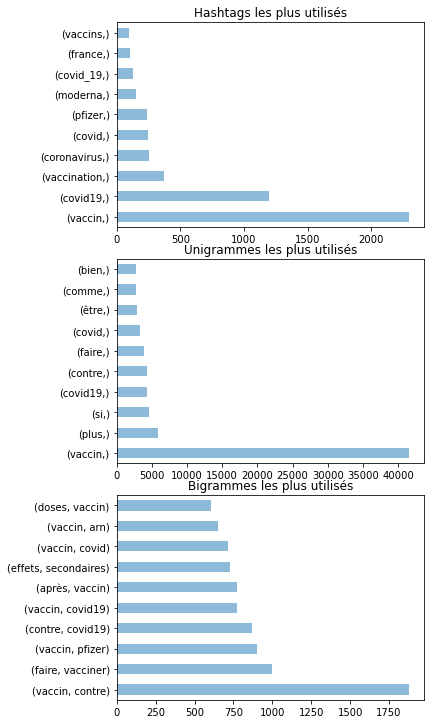

In [93]:
# on peut maintenant tracer des histogrammes
fig, ax = plt.subplots(3,1,figsize=(5,10))
fig.tight_layout()

#hashtags
common_hashtags=pd.DataFrame(hashtag_list,columns=['hashtag']).value_counts().sort_values(ascending=False)
common_hashtags.head(10).plot(kind='barh',ax=ax[0],alpha=0.5)
ax[0].set_title('Hashtags les plus utilis√©s')
ax[0].set_ylabel('')


#unigrammes
common_unigrams=pd.DataFrame(bag_of_words_list,columns=['unigram']).value_counts().sort_values(ascending=False)
common_unigrams.head(10).plot(kind='barh',ax=ax[1],alpha=0.5)
ax[1].set_title('Unigrammes les plus utilis√©s')
ax[1].set_ylabel("")

#bigrammes
bigrams=list(nltk.bigrams(bag_of_words_list))
common_bigrams=pd.DataFrame(bigrams,columns=['bigram_first_word','bigram_second_word']).value_counts().sort_values(ascending=False)
common_bigrams.head(10).plot(kind='barh',ax=ax[2],alpha=0.5)
ax[2].set_title('Bigrammes les plus utilis√©s')
ax[2].set_ylabel("")
plt.show()

- On retrouve des mots coh√©rents : li√©s √† la vaccination ("vaccin", "faire vacciner", "vaccination"), √† la maladie ("covid19", "coronavirus" etc), aux marques ("pfizer", "moderna" etc). On remarque √©galement  que les bigrammes "vaccin arn" et "effets secondaires" sont parmi les bigrammes les plus pr√©valents. 
- On peut √©galement repr√©senter un nuage de mots. La fonction word_cloud permet d'afficher les unigrammes et bigrammes les plus fr√©quents. Plus la taille d'un mot (ou groupe de mot) est √©lev√©e, plus le mot est pr√©sent dans le dataset. On retrouve logiquement les m√™mes mots que dans les graphiques pr√©c√©dents sous une forme plus visuelle. 

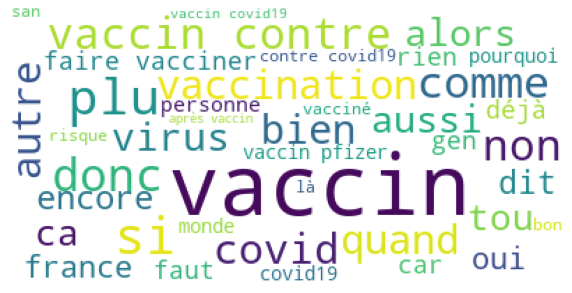

In [557]:
fig, ax = plt.subplots(figsize=(10,10))

# relative scaling=0.5 permet de pond√©rer aussi bien le nombre d'occurences du mot que le rang du mot
wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=60,relative_scaling=0.5,collocations=True).generate(bag_of_words)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 2) Segmentation des sujets via la LDA

- Une fois notre dataset pris en main nous allons essayer d'identifier des th√®mes dans les d√©bats li√©s aux vaccins. Pour ce faire nous recourrons √† un mod√®le de LDA (Latent Dirichlet Allocation). 
- Pour entra√Æner un mod√®le LDA on lui fournit une collection de documents sous la forme d'un ensemble de vecteurs de m√™me taille (ici la taille du vocabulaire). Le mod√®le LDA va grouper les documents dans diff√©rents clusters en partant du principe que les documents appartenant √† un m√™me topic ont recours √† un vocabulaire proche.  
- Apr√®s de premiers essais et afin d'√©viter que les mots les plus courants (et en particulier "vaccin") ne viennent polluer notre mod√®le, on s'assure d'exclure dans le mod√®le les mots pr√©sents dans plus de 80% des documents. 

### Fonctions de base

On commence par cr√©er deux fonctions de base : la premi√®re entra√Æne un mod√®le LDA √† partir d'une base de documents et un nombre de topics pr√©d√©fini. La seconde permet d'afficher les mots cl√©s les plus pr√©sents pour chaque topic identifi√© par le mod√®le. 

In [558]:
# fonction LDA (renvoie trois arguments : le mod√®le, le corpus et le dico)
def create_LDA_model(clean_documents,n_topics):
    final_dict={}
    # on cr√©e un dictionnaire √† partir de notre base de documents
    dico = corpora.Dictionary(clean_documents)
    # on retire les mots pr√©sents dans + de 80% du dataset et les mots avec moins de 5 occurences
    dico.filter_extremes(no_above=0.8,no_below=5) 
    # on sauvegarde le dictionnaire
    final_dict['dico']=dico
    # on cr√©e un corpus √† partir de nos documents
    corpus = [dico.doc2bow(document) for document in clean_documents]
    # on sauvegarde le corpus
    final_dict['corpus']=corpus
    #on entra√Æne le mod√®le
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dico,num_topics=n_topics,passes=3)
    final_dict['model']=lda_model
    return(final_dict) # le mod√®le renvoie donc pour une base de documents le dictionnaire, le mod√®le et le corpus

# fonction afficher les topics et les mots les plus pr√©sents
def build_topic_list(lda_model,no_words,n_topics):
    dict={}
    columns=['keywords_list']+['Weights_n¬∞1']
    columns+=["W_n¬∞"+str(i+1) for i in range(1,no_words)]
    for i in range(0,n_topics):
        keyword_vector=lda_model.show_topic(i)
        keyword_list=np.asarray(", ".join([word for word,prop in keyword_vector][0:no_words]))
        prop_list=[round(100*prop,1) for word,prop in keyword_vector][0:no_words]
        final_list=np.append(keyword_list,prop_list)
        dict["Topic %d" %(i)]=final_list
    return(pd.DataFrame.from_dict(dict,orient='index',columns=columns))

### Mod√®le de base

- On commence par un premier essai avec un nombre arbitraire de 5 sujets, le mod√®le LDA renvoie les cinq sujets avec les mots les plus pr√©sents dans le topic ainsi que le poids associ√© √† chaque mot. 

In [95]:
# MOD√àLE DE BASE
clean_documents_base=[clean_tweet for clean_tweet in tw_data['clean_vector'].values]
lda_base=create_LDA_model(clean_documents_base,n_topics=5)

# on affiche le dictionnaire avec les topics et les mots les plus courants
base_topic_list=build_topic_list(lda_model=lda_base['model'],no_words=10,n_topics=5)
base_topic_list

keywords_list Weights_n¬∞1 W_n¬∞2  \
Topic 0  covid19, contre, vaccination, covid, graves, n...         2.2   1.8   
Topic 1  arn, virus, sans, vaccins, variant, cette, plu...         1.4   1.2   
Topic 2  si, faire, plus, non, rien, comme, effets, vac...         1.8   1.5   
Topic 3  plus, si, √™tre, faire, covid, va, bien, virus,...         1.9   1.1   
Topic 4  covid19, apr√®s, vaccination, contre, doses, pf...         4.6   2.2   

        W_n¬∞3 W_n¬∞4 W_n¬∞5 W_n¬∞6 W_n¬∞7 W_n¬∞8 W_n¬∞9 W_n¬∞10  
Topic 0   1.3   1.0   0.9   0.8   0.8   0.8   0.7    0.7  
Topic 1   0.8   0.8   0.8   0.7   0.7   0.6   0.6    0.6  
Topic 2   1.4   1.0   0.9   0.9   0.9   0.9   0.8    0.8  
Topic 3   1.1   1.0   1.0   0.9   0.8   0.8   0.8    0.7  
Topic 4   2.1   2.0   1.8   1.7   1.4   1.4   1.2    1.2

### Choix de l'hyperparam√®tre : nombre de topics

Pour choisir le meilleur nombre de topics on utilise le score de coh√©rence. La coh√©rence permet de mesurer la pertinence d'un topic en mesurant la similarit√© entre les mots les plus importants de ce topic. On utilise la mesure c_v qui se fonde sur la similarit√© cosinus et la NPMI (information mutuelle ponctuelle normalis√©e qui quantifie le rapport entre la loi jointe/proba que deux √©v√©n√®nements coincident et le produit de leurs lois marginales). 

On commence par cr√©er deux fonctions de base permettant l'une de calculer la coh√©rence du mod√®le, l'autre de dessiner un graphique indiquant la coh√©rence pour diff√©rents nombres de topics. 

In [96]:
# fonction coherence score
def calcul_coherence(model,documents,type='c_v'):
    corpus=model['corpus']
    dico=model['dico']
    model=model['model']
    coherence_model_lda = CoherenceModel(model,texts=documents,corpus=corpus,dictionary=dico,coherence=type)
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

def draw_coherence(documents,min=1,max=10,type='c_v'):
    coherence_scores=[]
    for n_topics in tqdm(range(min,max+1)):
        model=create_LDA_model(documents,n_topics=n_topics)
        coh=calcul_coherence(model,documents=documents,type=type)
        coherence_scores.append(coh)
    fig, ax = plt.subplots(figsize=(5,5))
    label=range(min,max+1)
    plt.plot(label,coherence_scores)
    ax.set_title('Variation du score de coh√©rence en fonction du nombre de topics :({})'.format(type))
    plt.show()

On peut d√©sormais tracer le graphique indiquant la coh√©rence du mod√®le pour diff√©rents nombres de topics (entre 1 et 10). 

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [05:24<00:00, 32.46s/it]


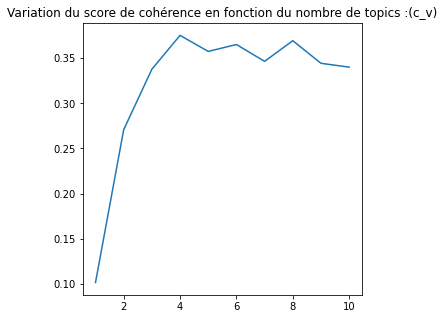

In [97]:
# on trace la coh√©rence en fonction du nombre de topics
draw_coherence(documents=clean_documents_base)

On constate que le gain marginal de coh√©rence est n√©gatif ou tr√®s faible lorsqu'on d√©passe quatre topics. On d√©cide donc de s'en tenir √† quatre topics majeurs et on construit notre mod√®le final. 

# IV. Exploration des groupes obtenus via la LDA

On choisit donc **comme mod√®le final le mod√®le √† 4 topics**. Il s'agit maintenant de mieux comprendre les th√®mes ressortis de la segmentation. Il s'agit d'un processus d√©licat, on va donc utiliser plusieurs m√©thodes qu'on recroisera pour arriver √† des r√©sultats satisfaisants : analyse lexicale, tweets les plus probables, utilisateurs les plus repr√©sentatifs pour chaque topic, polarit√©/objectivit√© de chaque topic. 

In [318]:
lda_final=create_LDA_model(clean_documents_base,n_topics=4)

Topic 0    plus, pfizer, arn, vaccins, covid19, contre, a...
Topic 1    covid19, vaccination, contre, apr√®s, france, d...
Topic 2    faire, rien, si, plus, bien, vacciner, va, non...
Topic 3    plus, si, virus, covid, faire, donc, comme, no...
Name: keywords_list, dtype: object

## 1) Exploration des sujets et des mots

In [561]:
# mots les plus pr√©sents dans chacun des sujets
build_topic_list(lda_model=lda_final['model'],no_words=10,n_topics=4)
for i, element in enumerate(base_topic_list['keywords_list']):
    print('\nTopic' +str(i))
    print(element)


Topic0
plus, pfizer, arn, vaccins, covid19, contre, ans, efficacit√©, virus, comme

Topic1
covid19, vaccination, contre, apr√®s, france, doses, coronavirus, via, dose, avoir

Topic2
faire, rien, si, plus, bien, vacciner, va, non, √™tre, contre

Topic3
plus, si, virus, covid, faire, donc, comme, non, √™tre, contre


Pour ce faire une meilleure id√©es des th√®mes on utilise une visualisation Davis. Chaque bulle repr√©sente un topic - plus grosse est la bulle, plus le topic est pr√©valent. Sur la fen√™tre de droite le param√®tre lambda sert √† ajuster le score de "pertinence". La documentation du mod√®le nous indique que la pertinence du mot w dans le sujet k est calcul√©e comme indiqu√©e ci-dessous: 

$r(w|k)=\lambda \times log(\phi_{kv})+(1-\lambda)\times log(\frac{\phi_{kv}}{p_w})$ avec $p_{w}$ la distribution du mot dans le corpus, $\phi_{kv}$ distribution du mot dans le topic. 

Quand $\lambda$ vaut 1 il s'agit simplement du mot le plus pr√©sent dans le topic, quand $\lambda$ diminue on prend de plus en plus compte les mots **relativement** tr√®s pr√©sents dans le topic (par rapport au reste du corpus) ce qui permet d'identifier des mots tr√®s sp√©cifiques √† chaque topic. 

In [365]:
vis = pyLDAvis.gensim.prepare(lda_final['model'], lda_final['corpus'], lda_final['dico'],sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015713  0.173663       1        1  24.985656
1     -0.233489 -0.047370       2        1  20.116918
2      0.109158 -0.132607       3        1  23.292555
3      0.108618  0.006314       4        1  31.604871, topic_info=            Term         Freq        Total Category  logprob  loglift
229      covid19  4852.000000  4852.000000  Default  30.0000  30.0000
331  vaccination  2779.000000  2779.000000  Default  29.0000  29.0000
29         apr√®s  2459.000000  2459.000000  Default  28.0000  28.0000
210       france  1513.000000  1513.000000  Default  27.0000  27.0000
126        doses  1369.000000  1369.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
162        moins   624.375385  1239.441242   Topic4  -5.5090   0.4662
47          dire   630.697199  1285.774108   Topic4  -5.4989   0.4396
133        alors   673.652223  1659.472049   Topic4  -5.4330   0.2503
20          peut   677.156733  1752.407566   Topic4  -5.4278   0.2010
73         avoir   655.049013  2132.941881   Topic4  -5.4610  -0.0287

[361 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1318      1  0.006915            1√®re
1318      2  0.988832            1√®re
1318      4  0.006915            1√®re
167       1  0.991408              2e
904       2  0.997643  administration
...     ...       ...             ...
2347      2  0.004368               ü§£
2347      3  0.856181               ü§£
4585      4  0.991886              ü§£ü§£
2973      1  0.010926              ü§∑‚Äç
2973      4  0.983295              ü§∑‚Äç

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

On peut d√©j√† remarquer gr√¢ce aux mots et √† la visualisation que : 
- le sujet 1 est le seul pour lequel les termes "arn" et "messager" appara√Æssent ainsi que des termes sp√©cifiques tels que "th√©rapie", "immunit√©, "variant", "g√©nique" etc. On a l'intuition que ce th√®me est plut√¥t "scientifique".
- le sujet 2 se caract√©rise par des mots issus de gestion politique de la vaccination : "dose", "france", "europe", "campagne", "fran√ßais", "millions". 
- Les sujets 3 et 4 sont plus difficiles √† diff√©rencier. Ils semblent tous les deux caract√©ris√©s par des jugements de valeur et des opinions. On peut remarquer que le sujet 3 semble finalement utiliser du lexique plus g√©n√©ral sur la p√©riode de pand√©mie ("libert√©", "masque", "droit", "gouvernement", "monde") quand le sujet 4 est plus centr√© sur des th√®mes li√©s au vaccin et √† la maladie ("effets secondaires", "prot√®ge", "cas graves"). 

## 2) Tweets les plus repr√©sentatifs pour chaque classe

On va pour chaque document de la base de donn√©es associer un vecteur de probabilit√©s pour chaque topic (topic_dis), le topic le plus probable (main_topic) et le pourcentage de probabilit√© pour ce topic (perc_main_topic). Par exemple pour le premier tweet de la base de donn√©es (dont on affiche la sortie) le topic identifi√© est le deuxi√®me topic avec une probabilit√© de 37%. 

In [565]:
# on r√©cup√®re la proba de chaque topic pour chaque tweet
tw_data['topic_dis']=tw_data['clean_vector'].apply(lambda x : lda_final['model'].get_document_topics(lda_final['dico'].doc2bow(x)))
# on trie le vecteur de probabilit√©s de fa√ßon √† avoir le topic le plus probable en premier
tw_data['sorted_topic']=tw_data['topic_dis'].apply(lambda x :sorted(x,key=lambda x: (x[1]),reverse=True))
# on extrait le topic le plus probable et sa proba associ√©
tw_data['main_topic']=tw_data['sorted_topic'].apply(lambda x :x[0][0])
tw_data['perc_main_topic']=tw_data['sorted_topic'].apply(lambda x :x[0][1])

In [566]:
tw_data[['text','topic_dis','main_topic','perc_main_topic']].head(1)

text  \
0  hahaha y‚Äôa des gens ils veulent trop faire les...   

                                           topic_dis  main_topic  \
0  [(0, 0.24085231), (1, 0.012797809), (2, 0.3734...           2   

   perc_main_topic  
0         0.373405

On peut ensuite pour chaque cat√©gorie afficher les cinq tweets les plus repr√©sentatifs. 

In [571]:
for i in range(0,4):
    df=tw_data[tw_data['main_topic']==i].sort_values(by='perc_main_topic',ascending=False)
    print('TWEET LES PLUS PROBABLES POUR LE TOPIC {} : '.format(i+1))
    for j in range(0,5):
        print("Tweet n*"+str(j+1))
        print(df['text'].values[j].strip())
    print('\\')

TWEET LES PLUS PROBABLES POUR LE TOPIC 1 : 
Tweet n*1
et l'ARN ne reste pas dans la cellule 
de fa√ßon permanente car la cellule d√©truit l'ARN assez rapidement
 
donc,il n'y a aucun risque qu'un vaccin √† ARN modifie g√©n√©tiquement le g√©nome d'une personne

cela semble √™tre une r√©ponse solide 
c‚Äôest la r√©ponse des fabricants de vaccins
Tweet n*2
Sur l'enjeu des vaccins, ils se foutent de ce que le f√©d√©ral peut dire, au sujet du d√©lai pour le 2e vaccin.
Quand je vous disais que le risque est tr√®s √©lev√©:  gaspillage de tous les vaccins et/ou protection diminu√©e.
D√®s le d√©but, les compagnies productrices ont bien √©tabli
Tweet n*3
üá´üá∑ "Notre vaccin prot√©gera sans doute une personne de moins de 55 ans en bonne sant√© pour plusieurs ann√©es. Mais pour celles qui sont plus √¢g√©es et √† la sant√© d√©j√† fragile, la dur√©e sera peut-√™tre plus courte" St√©phane Bancel, PDG de Moderna (L‚ÄôExpress) https://t.co/emKsXRfEud
Tweet n*4
@Lilly_Crem C‚Äôest la technique m√™me 

S'il est difficile de trop s'avancer avec cet √©chantillon, on retrouve tout de m√™me le fait que le topic 1 semble associ√© avec le th√®me de l'ARN qui revient sur trois tweets et sur des discussions utilisant des th√®mes scientifiques. Le topic 2 semble lui associ√© avec des tweets officiels (venant de m√©dias notamment) ce qui explique qu'on y ait retrouv√© des informations √† caract√®re plus politique. Le topic 3 est bien li√© avec la pand√©mie de mani√®re plus g√©n√©rale (mesures barri√®res, confinement) alors que le topic 4 semble centr√© sur le d√©bat autour de la vaccination avec des arguments pas toujours tr√®s objectifs ...

## 3) Analyse de subjectivit√© et de polarit√©

On va coupler notre analyse avec une analyse de sentiments en utilisant le module TextBlob. Pour une phrase donn√©e, le module accorde un score de polarit√© (positif = 1, n√©gatif=-1) et de subjectivit√© (0=objectif, 1=subjectif) √† la phrase √† partir d'un lexique de mots annot√©s. On rajoute √† notre dataframe la polarit√© et la subjectivit√©. Puis on trace des graphiques pour chacun des topics et on calcule les scores moyens (ainsi que les quartiles) pour chacun des topics. 

In [572]:
tw_data['polarity']=tw_data['text'].apply(lambda x : TextBlob(x,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer()).sentiment[0])
tw_data['objectivity']=tw_data['text'].apply(lambda x : TextBlob(x,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer()).sentiment[1])

In [574]:
fig, ax = plt.subplots(2, 4,figsize=(15,8))
fig.tight_layout()

# dictionnaire afin de stocker les valeurs moyennes
emo_dict={}

for i in range(0,4):
    vect=[]
    ax_1=ax[0,i]
    ax_2=ax[1,i]
    polarities=[pol for pol in tw_data[tw_data['main_topic']==i]['polarity']]
    vect.append(np.mean(polarities))
    vect.append(np.percentile(polarities, 25))
    vect.append(np.percentile(polarities, 75))
    ax_1.hist(polarities,bins=100,alpha=0.5)
    ax_1.set_title('Polarit√© ('+str(i+1)+')')
    objectivity=[obj for obj in tw_data[tw_data['main_topic']==i]['objectivity']]
    vect.append(np.mean(objectivity))
    vect.append(np.percentile(objectivity, 25))
    vect.append(np.percentile(objectivity, 75))
    ax_2.hist(objectivity,bins=150,alpha=0.5)
    ax_2.set_title('Objectivit√© ('+str(i+1)+')')
    ax_2.set_xlim(0,1)
    emo_dict['Topic'+str(i+1)]=vect

plt.show()

In [575]:
# moyenne de polarit√© et d'objectivit√©
pd.DataFrame.from_dict(emo_dict, orient='index',dtype=None, columns=['Polarity_mean','Pol_Q1','Pol_Q3','Objectivity_mean','Obj_Q1','Obj_Q3'])

Polarity_mean        Pol_Q1    Pol_Q3  Objectivity_mean  Obj_Q1  \
Topic1       0.065509  0.000000e+00  0.160536          0.210914   0.000   
Topic2       0.078123  0.000000e+00  0.162625          0.154228   0.000   
Topic3       0.047043 -2.500000e-03  0.147500          0.255479   0.025   
Topic4       0.064695 -4.394633e-18  0.160000          0.277728   0.100   

          Obj_Q3  
Topic1  0.325000  
Topic2  0.241667  
Topic3  0.350000  
Topic4  0.375000

Tous les topics ont une polarit√© moyenne l√©g√®rement positive, ce qui ne permet pas de faire de vraies conclusions (on est assez d√©√ßu). Le topic 2 que l'on avait associ√© √† des informations venus de m√©dias est celui avec la plus forte objectivit√© ce qui semble aller dans notre sens. Les sujets 3 et 4 sont class√©s comme les plus subjectifs ce qui est aussi conforme avec notre analyse pr√©c√©dente. 

## 4) Analyse des sources

On s'int√©resse aux utilisateurs les plus fr√©quents pour chacun des topics. On affiche les cinq premiers utilisateurs ainsi que leur nombre de tweets dans la cat√©gorie et leur description.  

In [576]:
for i in range(0,4):
    print('Topic '+str(i+1))
    df=tw_data[tw_data['main_topic']==i]
    print(tabulate(df.groupby(['main_topic'])['user_name'].value_counts().groupby(level=[0]).head(5).reset_index(name='count'),tablefmt='pretty',showindex=False))
    print(df.groupby(['main_topic'])['user_description'].value_counts().groupby(level=[0]).head(5).reset_index(name='count')['user_description'])
    #print(tabulate(df.groupby(['main_topic'])['user_description'].value_counts().groupby(level=[0]).head(5).reset_index(name='count')['user_description'],tablefmt='pretty',showindex=False))

Topic 1
+---+---------------------------------------+----+
| 0 | Dr Jean-Jacques Fraslin - No #FakeMed | 23 |
| 0 |                   .                   | 20 |
| 0 |             StevePascolo              | 17 |
| 0 |            Eric Billy üá´üá∑üá™üá∫            | 16 |
| 0 |               EVA REVE                | 15 |
+---+---------------------------------------+----+
0    M√©decin g√©n√©raliste.\nEn 2019, j'ai surv√©cu gr...
1    co-fondateur CureVac. Expert vaccins ARN messa...
2    geneticist, #CRISPR, oncology/cancer, project ...
3    #Altruisme #Bienveillance #innovation #startup...
4    Neurones √† la recherche de la v√©rit√© J‚Äôaime le...
Name: user_description, dtype: object
Topic 2
+---+---------------------------------------+----+
| 1 |             FranceNews24              | 23 |
| 1 |          Jean Marc Morandini          | 21 |
| 1 |          Derni√®res nouvelles          | 19 |
| 1 | Dr Jean-Jacques Fraslin - No #FakeMed | 19 |
| 1 |             Nashira News       

Les trois utilisateurs les plus pr√©sents dans le topic 1 semblent √™tre des personnes qualifi√©es (un m√©decin, un expert de l'ARN et un g√©n√©ticien) ce qui nous conforte dans le th√®me scientifique du premier topic. On constate aussi que le topic 2 est bien reli√© avec les actualit√©s et les m√©dias. Il est encore une fois plus difficile de faire de vraies conclusions sur les deux derniers th√®mes m√™me si l'on remarque encore une fois que la subjectivit√© est de mise avec des descriptions d'utilisateurs telles que "pour plus de justice et de libert√© - d√©teste le politiquement correct","je viens pour dire ce que je pense", "sortir de l'obscurantisme et contre la censure".  

In [592]:
# on code une nouvelle colonne pour savoir si le tweet est ou non une r√©ponse adress√©e √† un autre utilisateur
tw_data['reply_code']=tw_data['is_reply'].notnull()
# on affiche les donn√©es moyennes pour les utilisateurs de chaque topic
tw_data.groupby(['main_topic']).mean()

tweet_id  tweet_location  is_retweet  is_quote_status  \
main_topic                                                                     
0           1348345382271465984             NaN         0.0         0.106126   
1           1348343911610714368             NaN         0.0         0.111616   
2           1348345009186707968             NaN         0.0         0.105875   
3           1348341928930643968             NaN         0.0         0.089850   

            user_followers  user_favourites  user_verified  perc_main_topic  \
main_topic                                                                    
0             12530.801108     15651.369867       0.025310         0.593985   
1             37896.537753     15892.850000       0.077778         0.616366   
2              6933.448926     16103.357409       0.015125         0.603317   
3              5191.981594     15306.667418       0.009541         0.627719   

            polarity  objectivity  reply_code  
main_topic                                     
0           0.065509     0.210914    0.647621  
1           0.078123     0.154228    0.335859  
2           0.047043     0.255479    0.700241  
3           0.064695     0.277728    0.756442

On remarque encore une fois que les utilisateurs du deuxi√®me groupe semblent √™tre des comptes plus "fiables" avec le plus fort pourcentage d'utilisateurs v√©rifi√©s et un nombre moyen de followers bien plus √©lev√© que dans les autres groupes. Les groupes 1, 2 et 3 sont caract√©ris√©s par beaucoup d'√©changes puisque 65% (groupe 1), 70% (groupe 3) et 75% (groupe 4) des tweets √©chang√©s sont des r√©ponses ou des interpellations d'autre utilisateurs quand le groupe 2 (d√©fini comme objectif) ne comporte qu'un tiers de tags d'utilisateurs. Au sein des ces trois groupes de d√©bat on distingue le groupe 1 avec des utilisateurs plus influents (moyenne de 12 500 followers) contre des utilisateurs moins suivis dans les groupes 3 et 4. 

# V. Conclusion et limites

### Conclusion sur les topics

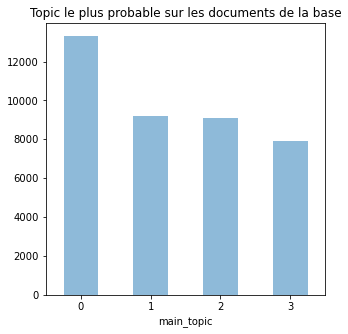

In [533]:
fig, ax = plt.subplots(figsize=(5,5))
topics=pd.DataFrame(tw_data['main_topic'],columns=['main_topic']).value_counts().sort_values(ascending=False)
topics.plot(kind='bar',ax=ax,alpha=0.5)
ax.set_title('Topic le plus probable sur les documents de la base')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.show()

#### Pour r√©capituler on identifie quatre sujets √† la lumi√®re de cette √©tude : 
- un d√©bat scientifique "√©clair√©" sur le vaccin et notamment ses sp√©cificit√©s (technologie ARN-m) o√π les utilisateurs √©changent en utilisant des th√®mes scientifiques et o√π des "experts" (m√©decins) semblent repr√©sent√©s (topic 1)
- des informations objectives sur l'actualit√© vaccinale provenant principalement de m√©dias (topic 2)
- des d√©bats tr√®s subjectifs d'utilisateurs moins influents autour de la pand√©mie et de la vie en tant de Covid sans forc√©ment d√©battre express√©ment de la vaccination (topic 3)
- un d√©bat tr√®s subjectif √©galement centr√© autour des risques/avantages de la vaccination (topic 4)

D'apr√®s la r√©partition des topics, les tweets les plus pr√©sents sont ceux qui adoptent un vocabulaire scientifique et technique pour parler du vaccin ce qui refl√®te les d√©bats sp√©cifiques li√©s √† la nouvelle technologie d'ARN-m utilis√© dans les nouveaux vaccins. Le mot "arn" √©tait d'ailleurs un des plus saillants du topic montrant qu'il est la source de nombreux d√©bats. On peut √©galement constater que les tweets objectifs et neutres (associ√©s le plus souvent √† la presse) repr√©sentent √† peine 25% des tweets √©chang√©s sur le sujet du vaccin. 

### Limites et suites √† donner
- les interpr√©tations de nos groupes sont forc√©ment tr√®s subjectives
- le fait d'avoir utilis√© un mod√®le de LDA pr√©sente les m√™mes d√©fauts que le recours √† un bag of words puisque chaque mot est analys√© ind√©pendamment des liens qu'il peut avoir avec d'autres mots. De plus certains mots tr√®s ressemblants (fautes d'orthographe ou m√™me radical) n'ont pas √©t√© rassembl√©s par le mod√®le. Nous avions essay√© un mod√®le avec radicalisation mais le manque d'interpr√©tabilit√© du mod√®le sans gain significatif de coh√©rence nous a conduit √† privil√©gier le mod√®le de base. 
- la quantit√© de tweets limit√©s ne permet que de r√©fl√©ter l'opinion sur la semaine √©tudi√©e. L'API de Twitter nous limitant √† une semaine de donn√©es il faudrait poursuivre l'√©tude pour √©tudier des variations d'opinion en fonction de nouvelles annonces.
- enfin la population de Twitter n'est pas repr√©sentative de la population fran√ßaise et a tendance √† plus catalyser les opinions extr√™mes comme tout r√©seau social